# IMDB Sentiment Analysis: Machine Learning Benchmark

## Overview
This notebook establishes a baseline performance for Sentiment Analysis on the IMDB Movie Reviews dataset using classical statistical machine learning models. The goal is to compare these algorithms against Deep Learning architectures found in this portfolio.

**Models Evaluated:**
1.  **Logistic Regression (SGD):** 
2.  **AdaBoost:** 
3.  **Random Forest (ID3):** 

In [ ]:
#!pip install datasets
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier , RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from scipy.sparse import vstack

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Data Loading and Splitting
Using the Hugging Face `datasets` library to ensure consistency with the Deep Learning models. The dataset is split into:
* **Training Set:** Used for model fitting (80% of training data).
* **Development (Dev) Set:** Used for hyperparameter tuning and feature selection validation(20% of training data).
* **Test Set:** Held out strictly for final evaluation.

In [6]:
dataset = load_dataset("imdb")

x_train_full = dataset['train']['text']
y_train_full = dataset['train']['label']

x_test = dataset['test']['text']
y_test = dataset['test']['label']

x_train , x_dev , y_train , y_dev = train_test_split(x_train_full , y_train_full , test_size = 0.2 , random_state=42 , stratify=y_train_full)

print(f"Training data: {len(x_train)}")
print(f"Development data: {len(x_dev)}")
print(f"Testing data: {len(x_test)}")

Training data: 20000
Development data: 5000
Testing data: 25000


## Feature Engineering
Text data is converted into numerical vectors using a Bag-of-Words approach.

* **Vectorization:** We generate **Unigrams and Bigrams** to capture local context (e.g., "not good").
* **Feature Selection:** To reduce dimensionality and noise, we use the **Chi-Squared ($\chi^2$)** statistical test to select the top 10,000 most discriminative features.

In [8]:
k = 5
n = 0.8
m = 10000

vectorizer = CountVectorizer(binary = True , min_df = k , max_df = n , ngram_range = (1,2))

x_train_vec = vectorizer.fit_transform(x_train)
x_dev_vec = vectorizer.transform(x_dev)

ig_selector = SelectKBest(chi2, k= m)

x_train_final = ig_selector.fit_transform(x_train_vec, y_train)
x_dev_final = ig_selector.transform(x_dev_vec)

print("Feature Engineering Complete")

Feature Engineering Complete


##  Hyperparameter Optimization
We perform a Grid Search to optimize the **Logistic Regression** model. We tune:
* **Regularization Penalty:** L1 vs. L2 
* **Alpha (Learning Rate):** Testing values from $10^{-1}$ to $10^{-6}$.

The best parameters are selected based on accuracy on the Development set.

In [10]:
penalties = ['l1' , 'l2']

alphas = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]

best_score = 0
best_params = {}


for p in penalties:
    for a in alphas:
        clf = SGDClassifier( loss = 'log_loss' , penalty = p , alpha = a , max_iter = 1000 , random_state = 42)
        clf.fit(x_train_final , y_train)
        score = clf.score(x_dev_final , y_dev)
        if score > best_score :
            best_score = score
            best_params = {'penalty' : p , 'alpha': a}

print(f"Best Accuracy: {best_score:.4f}")
print(f"Best Params: {best_params}")

Best Accuracy: 0.8910
Best Params: {'penalty': 'l2', 'alpha': 0.001}


In [12]:
x_test_vec = vectorizer.transform(x_test)
x_test_final = ig_selector.transform(x_test_vec)

best_penalty = best_params['penalty']
best_alpha = best_params['alpha']

models = {
    "Logistic Regresion with SGD " : SGDClassifier(loss = 'log_loss' , penalty = best_penalty , alpha = best_alpha , max_iter = 1000 , random_state = 42),
    "AdaBoost" : AdaBoostClassifier( estimator = DecisionTreeClassifier(max_depth = 1), n_estimators = 100 , random_state = 42),
    "Random Forest ID3" : RandomForestClassifier ( criterion = 'entropy' , n_estimators = 100 , n_jobs = -1 , random_state = 42)
}   

In [14]:
def plot_learning_curves( model , name , x_tr , y_tr , x_d , y_d):
    train_sizes = np.linspace(0.1 , 1.0 , 5)
    scores = { 'prec': ([],[]) , 'rec' : ([],[]) , 'f1' : ([],[])}
    n_samples = x_tr.shape[0]

    for fraction in train_sizes:
        subset_size = int(n_samples * fraction)
        x_sub = x_tr[:subset_size]
        y_sub = y_tr[:subset_size]

        from sklearn.base import clone
        curr_model = clone(model)
        curr_model.fit(x_sub , y_sub)

        tr_pred = curr_model.predict(x_sub)
        dev_pred = curr_model.predict(x_d)

        scores['prec'][0].append(precision_score(y_sub, tr_pred, pos_label=1))
        scores['prec'][1].append(precision_score(y_d, dev_pred, pos_label=1))
        scores['rec'][0].append(recall_score(y_sub, tr_pred, pos_label=1))
        scores['rec'][1].append(recall_score(y_d, dev_pred, pos_label=1))
        scores['f1'][0].append(f1_score(y_sub, tr_pred, pos_label=1))
        scores['f1'][1].append(f1_score(y_d, dev_pred, pos_label=1))

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    x_ticks = (train_sizes * n_samples).astype(int)
    metrics_map = [('Precision', 'prec'), ('Recall', 'rec'), ('F1', 'f1')]

    for i, (title, key) in enumerate(metrics_map):
        axes[i].plot(x_ticks, scores[key][0], 'o-', color='r', label='Train')
        axes[i].plot(x_ticks, scores[key][1], 'o-', color='g', label='Dev')
        axes[i].set_title(f"{name} - {title}")
        axes[i].set_xlabel("Samples")
        axes[i].set_ylim(0.4, 1.05)
        axes[i].grid(True)
        if i==0: axes[i].legend()

    plt.tight_layout()
    plt.show()

## Model Evaluation & Learning Curves
We evaluate the three models on the Test set. We also plot **Learning Curves** to diagnose bias vs. variance:
* **Red Curve (Train):** Performance on training data.
* **Green Curve (Dev):** Performance on development data.

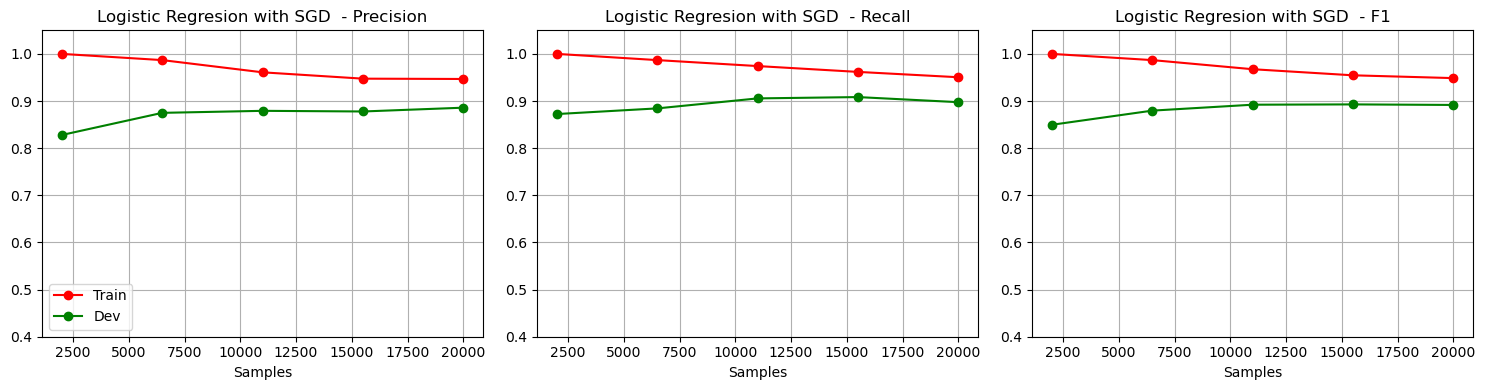

              precision  recall  f1-score
Negative       0.886160  0.9092  0.897532
Positive       0.906776  0.8832  0.894833
accuracy       0.896200  0.8962  0.896200
macro avg      0.896468  0.8962  0.896182
weighted avg   0.896468  0.8962  0.896182
--------------------


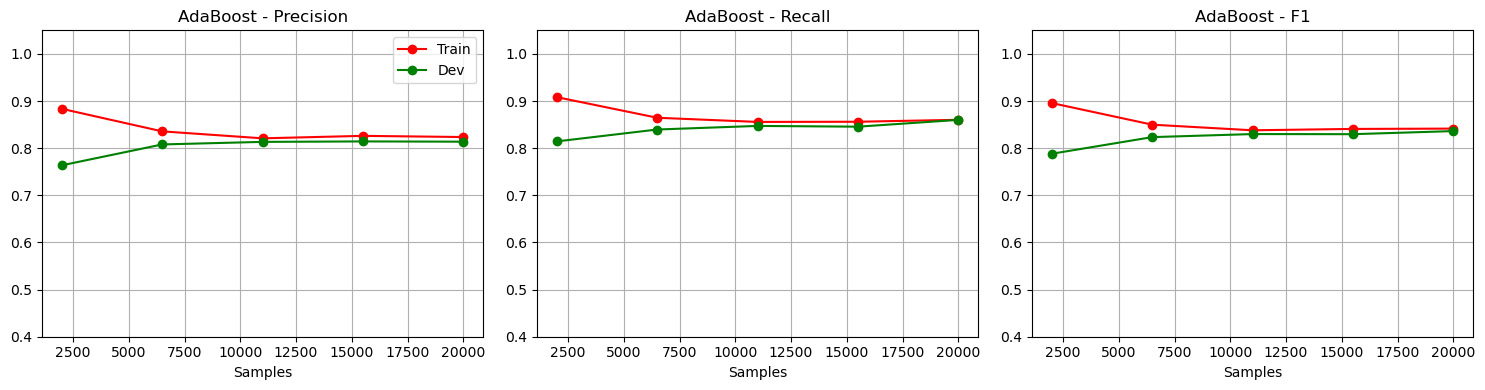

              precision   recall  f1-score
Negative       0.844398  0.81096  0.827341
Positive       0.818161  0.85056  0.834046
accuracy       0.830760  0.83076  0.830760
macro avg      0.831279  0.83076  0.830694
weighted avg   0.831279  0.83076  0.830694
--------------------


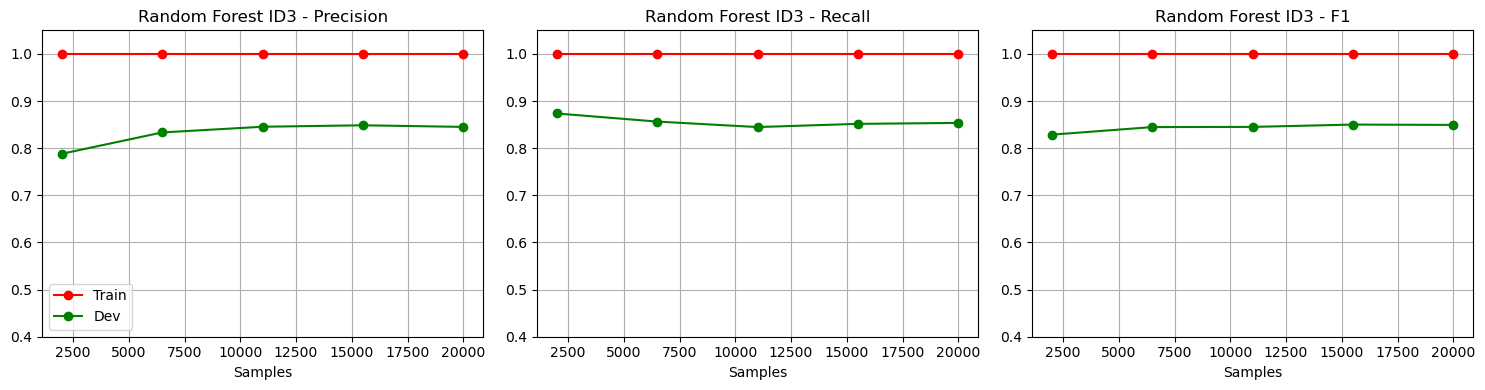

              precision   recall  f1-score
Negative       0.856499  0.85184  0.854163
Positive       0.852642  0.85728  0.854955
accuracy       0.854560  0.85456  0.854560
macro avg      0.854570  0.85456  0.854559
weighted avg   0.854570  0.85456  0.854559
--------------------


In [16]:
x_all_final = vstack([x_train_final, x_dev_final])
y_all = np.concatenate([y_train, y_dev])

for name , model in models.items():
    plot_learning_curves(model , name , x_train_final , y_train , x_dev_final , y_dev)
    model.fit(x_all_final , y_all)
    y_pred_test = model.predict(x_test_final)
    report = classification_report(y_test, y_pred_test, target_names=['Negative', 'Positive'], output_dict=True)
    df_res = pd.DataFrame(report).transpose()[['precision', 'recall', 'f1-score']]
    print(df_res)
    print("-" * 20)